In [1]:
import importlib
import numpy as np
import sys
sys.path.append("./AbstractCircuit")

# # First, import module objects
import AbstractCircuit
import DShor
import help_function
import FundamentalOperations
import AbstractRegister
from random import getrandbits
import QPU
import matplotlib.pyplot as plt

# Then reload the modules (if you're updating code dynamically)
importlib.reload(AbstractRegister)
importlib.reload(AbstractCircuit)
importlib.reload(DShor)
importlib.reload(help_function)
importlib.reload(FundamentalOperations)
importlib.reload(QPU)

# Finally, import names into the current namespace
from AbstractCircuit import *
from DShor import *
from help_function import *
from QPU import *
import AbstractGate
from CircuitDrawer import CircuitDrawer

%load_ext autoreload
%autoreload 2

In [2]:
from dataclasses import dataclass

@dataclass
class GateCost:
    def __init__(self, tM, tT, tInter):
        self.tM = tM
        self.tT = tT
        self.tInter = tInter

# allocate 10 exponent qubits and 2000 data qubits
Ne = 10
N = 8
num_QPU = 4

## Use this setting to draw the circuit
Ne = 4
N = 1000
num_QPU = 10
table = {}
for i in range(2**Ne):
    num = getrandbits(N)
    table[i] = num

In [4]:
QPU_assignment = defaultdict(list)
tT = 1
tM = 1
tInter = 20

tInter_lst = np.arange(1, 50, 2)
tT_lst = np.arange(1, 20)
result = np.zeros((len(tInter_lst), len(tT_lst)))
for l in range(len(tT_lst)):
    tT = tT_lst[l]
    for m in range(len(tInter_lst)):
        tInter = tInter_lst[m]
        QPU_assignment = defaultdict(list)
        gate_cost = GateCost(tM,tT,tInter)

        c = AbstractCircuit(0, {}, {})

        for i in range(Ne):
            c.add_data("control", pos = i)
            QPU_assignment[0].append(c.data[i])

        for i in range(num_QPU):
            for k in range(N//num_QPU):
                index = i*(N//num_QPU) + k
                c.add_data("target", pos = 2*index + Ne)
                QPU_assignment[i+1].append(c.data[2*index + Ne])

        for i in range(num_QPU):
            for k in range(N//num_QPU):
                index = i*(N//num_QPU) + k
                c.add_data("working", pos = 2*index + 1 + Ne)
                QPU_assignment[i+1].append(c.data[2*index + Ne + 1])

        control_qubits = []
        target_qubits = []
        working_qubits = []

        # qubits are ordered as [all exponent qubits, [target qubits[i], working qubits[i] for i = 1:2000]
        for i in range(Ne):
            control_qubits.append(c[i])

        for i in range(N):
            target_qubits.append(c[2*i+Ne])
            working_qubits.append(c[2*i+1+Ne])


        print(control_qubits[0].pos)

        antena_assignment = defaultdict(list)
        ghz_ancillas = defaultdict(list)

        for i in range(num_QPU-1):
            c.insert_data("GHZ_a", Ne+2*i+2*N//num_QPU*i)
            c.insert_data("GHZ_a", Ne+2*i+2*N//num_QPU*i + 1)
            ghz_ancillas[i].append(c.data[Ne+2*i+2*N//num_QPU*i])
            ghz_ancillas[i].append(c.data[Ne+2*i+2*N//num_QPU*i + 1])

        for i in range(num_QPU):
            c.insert_data("GHZ", Ne+2*i+(2*N//num_QPU + 2)*i)
            c.insert_data("GHZ", Ne+2*i+(2*N//num_QPU + 2)*i +  1)
            antena_assignment[i].append(c.data[Ne+2*i+(2*N//num_QPU + 2)*i])
            antena_assignment[i].append(c.data[Ne+2*i+(2*N//num_QPU + 2)*i + 1])

        print(antena_assignment)
        c.insert_data("antena_0", Ne)
        antena_assignment[0].append(c.data[Ne])
        print(len(antena_assignment), len(QPU_assignment))
        c.lookup(table, control_qubits, target_qubits, QPU_assignment = QPU_assignment, 
                antena_assignment = antena_assignment, antena_ancilla = ghz_ancillas, decompose = False, gate_cost = gate_cost)
        # c.add(target_qubits, working_qubits)
        # print(c.count_gate())
        # print(antena_assignment)
        # c.draw_circuit(if_text=True, if_line=True)
        drawer = CircuitDrawer()
        drawer.data = c.data
        drawer.ancilla = c.ancilla
        # drawer.draw_circuit(if_line=False, if_text=False)
        print(c.depth() - 2*tInter)
        result[m, l] = c.depth() - 2*tInter


0
defaultdict(<class 'list'>, {0: [<AbstractRegister.DataRegister object at 0x000000002AD4B450>, <AbstractRegister.DataRegister object at 0x000000002AD48550>], 1: [<AbstractRegister.DataRegister object at 0x000000002AD49A50>, <AbstractRegister.DataRegister object at 0x000000002AD48650>], 2: [<AbstractRegister.DataRegister object at 0x000000002AD4AF90>, <AbstractRegister.DataRegister object at 0x000000002AD49490>], 3: [<AbstractRegister.DataRegister object at 0x000000002AD497D0>, <AbstractRegister.DataRegister object at 0x000000002AD498D0>], 4: [<AbstractRegister.DataRegister object at 0x000000002AD4B690>, <AbstractRegister.DataRegister object at 0x000000002AD48C90>], 5: [<AbstractRegister.DataRegister object at 0x000000002AD4AE90>, <AbstractRegister.DataRegister object at 0x000000002AD4B090>], 6: [<AbstractRegister.DataRegister object at 0x000000002AD48810>, <AbstractRegister.DataRegister object at 0x000000002AD48310>], 7: [<AbstractRegister.DataRegister object at 0x000000002AD4A410>, 

In [ ]:
# result = result/result[0,0]
threshold = np.zeros(len(tT_lst))
for i in range(len(tT_lst)):
    for j in range(len(tInter_lst)):
        if result[j,i] > 1.05:
            threshold[i] = tInter_lst[j]
            break
print(threshold)

[25. 25. 25. 25. 25. 23.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.]


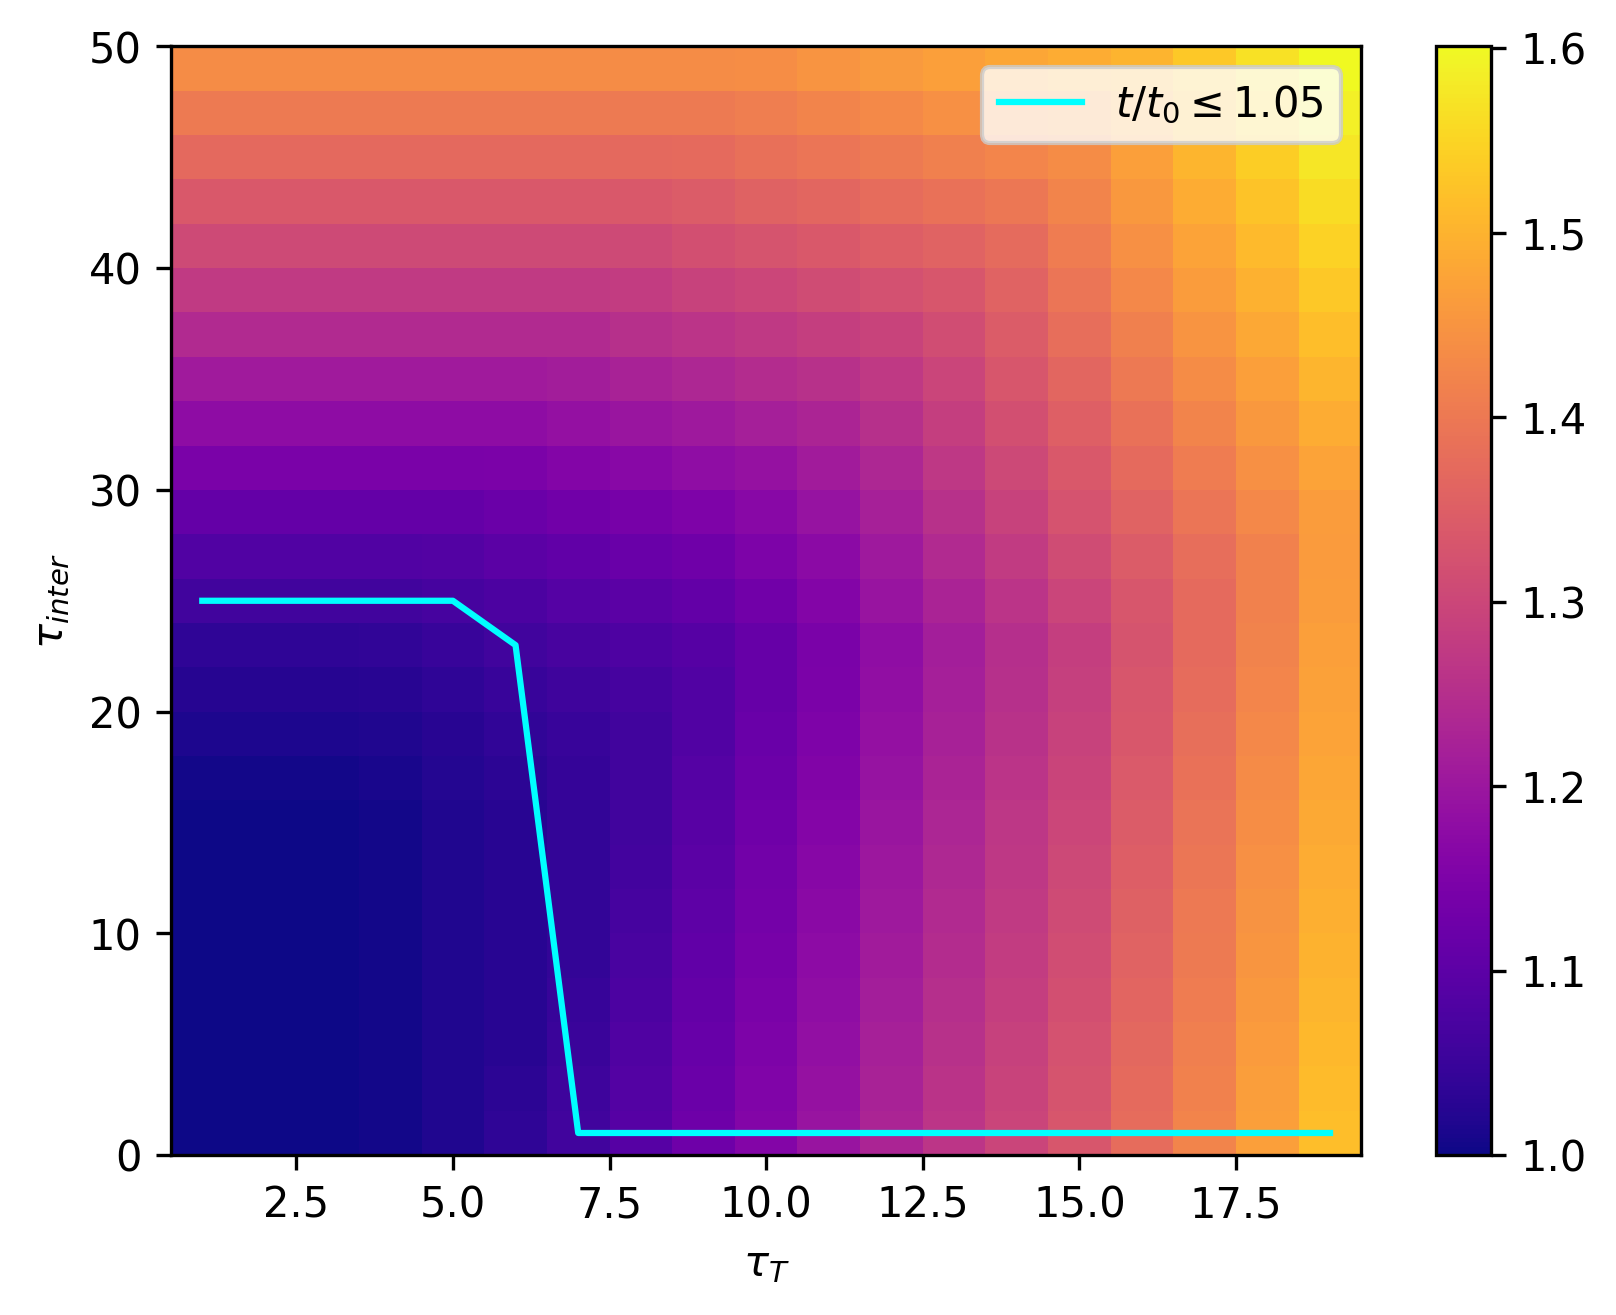

In [ ]:

fig, ax = plt.subplots(dpi=300)
x, y = np.meshgrid(tT_lst, tInter_lst)
# Plot colormap
c = ax.pcolormesh(x, y, result, cmap='plasma', shading='auto')
cb = fig.colorbar(c, ax=ax)
plt.xlabel(r"$\tau_T$")
plt.ylabel(r"$\tau_{inter}$")
ax.plot(tT_lst, threshold, color='cyan', label=r'$t/t_0 \leq 1.05$')
ax.legend()


In [ ]:
new_result = result.copy()
new_data = np.zeros((len(tInter_lst), len(tT_lst)))
for i in range(len(tT_lst)):
    new_data[:,i] = new_result[:,i]/new_result[0,i]

threshold = np.zeros(len(tT_lst))
print(len(threshold), len(tT_lst))
for i in range(len(tT_lst)):
    for j in range(len(tInter_lst)):
        if new_data[j,i] > 1.05:
            threshold[i] = tInter_lst[j]
            break
print(threshold)

19 19
[25. 25. 25. 25. 27. 27. 29. 31. 33. 35. 35. 37. 39. 41. 41. 43. 45. 47.
 49.]


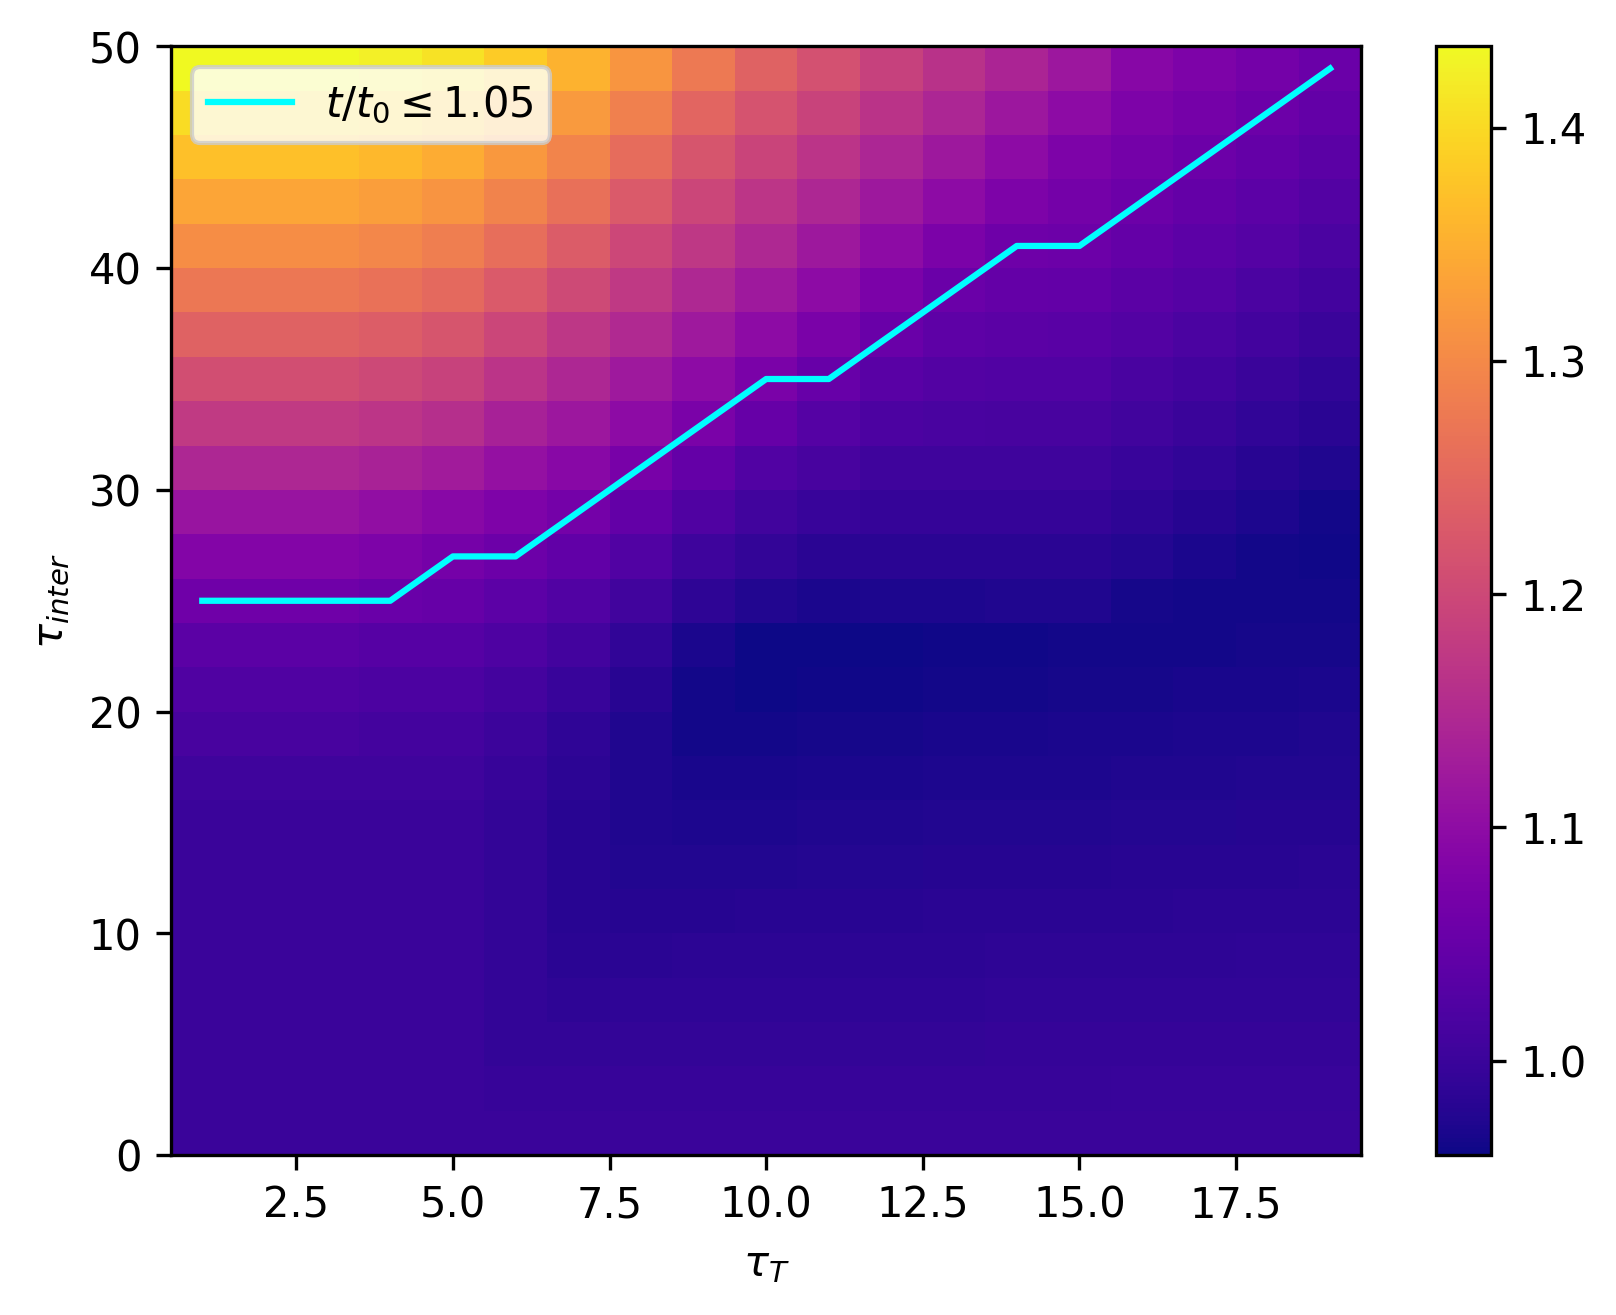

In [ ]:

fig, ax = plt.subplots(dpi=300)
x, y = np.meshgrid(tT_lst, tInter_lst)
# Plot colormap
c = ax.pcolormesh(x, y, new_data, cmap='plasma', shading='auto')
cb = fig.colorbar(c, ax=ax)
plt.xlabel(r"$\tau_T$")
plt.ylabel(r"$\tau_{inter}$")
ax.plot(tT_lst, threshold, color='cyan', label=r'$t/t_0 \leq 1.05$')
ax.legend()
